# ANALYSING CIC 2017 DATASET AND SELECTING BEST FEATURES FOR SLOWLORIS ATTACK


## Index
    1. Data Preparation
    2. Data Split
    3. Feature Selection
    4. PCA

In [2]:
import os
import subprocess
import seaborn as sns  
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from __future__ import print_function
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.feature_selection import VarianceThreshold, SelectKBest, chi2
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score,confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [3]:
def get_data():
    if os.path.exists("slow_loris_filtered.csv"):
        print("-- slow_loris.csv found locally")
    df = pd.read_csv("slow_loris_filtered.csv", index_col=False)
    return df

In [4]:
def encode_target(df, target_column):
    df_mod = df.copy()
    targets = df_mod[target_column].unique()
    map_to_int = {name: n for n, name in enumerate(targets)}
    df_mod["Target"] = df_mod[target_column].replace(map_to_int)
    return (df_mod, targets)

In [5]:
data = get_data()

-- slow_loris.csv found locally


# 1.0 Data processing

### We initially drop variables that won't contribute to knowlege of slowloris attack because they change from instance to instance

In [6]:
columns = ['Flow ID', ' Source IP', ' Source Port', ' Destination IP', ' Destination Port', ' Protocol', ' Timestamp',]
data.drop(columns, inplace=True, axis=1)
print(data.keys())
print(data.shape[0])
print(data.shape[1])

Index([u' Flow Duration', u' Total Fwd Packets', u' Total Backward Packets',
       u'Total Length of Fwd Packets', u' Total Length of Bwd Packets',
       u' Fwd Packet Length Max', u' Fwd Packet Length Min',
       u' Fwd Packet Length Mean', u' Fwd Packet Length Std',
       u'Bwd Packet Length Max', u' Bwd Packet Length Min',
       u' Bwd Packet Length Mean', u' Bwd Packet Length Std', u'Flow Bytes/s',
       u' Flow Packets/s', u' Flow IAT Mean', u' Flow IAT Std',
       u' Flow IAT Max', u' Flow IAT Min', u'Fwd IAT Total', u' Fwd IAT Mean',
       u' Fwd IAT Std', u' Fwd IAT Max', u' Fwd IAT Min', u'Bwd IAT Total',
       u' Bwd IAT Mean', u' Bwd IAT Std', u' Bwd IAT Max', u' Bwd IAT Min',
       u'Fwd PSH Flags', u' Bwd PSH Flags', u' Fwd URG Flags',
       u' Bwd URG Flags', u' Fwd Header Length', u' Bwd Header Length',
       u'Fwd Packets/s', u' Bwd Packets/s', u' Min Packet Length',
       u' Max Packet Length', u' Packet Length Mean', u' Packet Length Std',
       u' Packe

### We also need to convert lables into numeric values for classification

In [7]:
df2, targets = encode_target(data, " Label")



### We drop any rows that contain NaN

In [8]:
df2 = df2.dropna(axis=0, how='any')
df2.isnull().sum().sum()

0

### We also drop columns that have 0 variance

In [9]:
list_unq = (df2.apply(pd.Series.nunique) != 1)
list_unq[list_unq == 0]

 Bwd PSH Flags           False
 Fwd URG Flags           False
 Bwd URG Flags           False
 CWE Flag Count          False
Fwd Avg Bytes/Bulk       False
 Fwd Avg Packets/Bulk    False
 Fwd Avg Bulk Rate       False
 Bwd Avg Bytes/Bulk      False
 Bwd Avg Packets/Bulk    False
Bwd Avg Bulk Rate        False
dtype: bool

In [10]:
df2 = df2.loc[:, df2.apply(pd.Series.nunique) != 1]

# 2.0 Data split
## We split data in features, lables

In [11]:
features = list(df2.columns[:-2])
y = df2["Target"]
X = df2[features]

In [12]:
X

,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,...,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
0,1137846,10,10,851,3950,267,0,85.100000,99.870416,1953,...,5,32,0.0,0.00000,0,0,0.000,0.00000,0,0
1,512617,6,7,468,635,282,0,78.000000,122.846245,458,...,3,32,0.0,0.00000,0,0,0.000,0.00000,0,0
2,1266840,4,3,1095,2929,1095,0,273.750000,547.500000,1481,...,1,32,0.0,0.00000,0,0,0.000,0.00000,0,0
3,99,2,0,0,0,0,0,0.000000,0.000000,0,...,0,32,0.0,0.00000,0,0,0.000,0.00000,0,0
4,307666,7,6,451,5174,451,0,64.428571,170.461977,1448,...,1,32,0.0,0.00000,0,0,0.000,0.00000,0,0
5,183932,10,7,1599,6661,1599,0,159.900000,505.648198,1884,...,1,32,0.0,0.00000,0,0,0.000,0.00000,0,0
6,3,2,0,2791,0,1753,1038,1395.500000,505.581349,0,...,1,32,0.0,0.00000,0,0,0.000,0.00000,0,0
7,98,2,0,0,0,0,0,0.000000,0.000000,0,...,0,32,0.0,0.00000,0,0,0.000,0.00000,0,0
8,5715038,4,2,0,0,0,0,0.000000,0.000000,0,...,0,32,0.0,0.00000,0,0,0.000,0.00000,0,0
9,5585147,3,1,0,0,0,0,0.000000,0.000000,0,...,0,32,0.0,0.00000,0,0,0.000,0.00000,0,0


0    25466
1     5788
Name: Target, dtype: int64

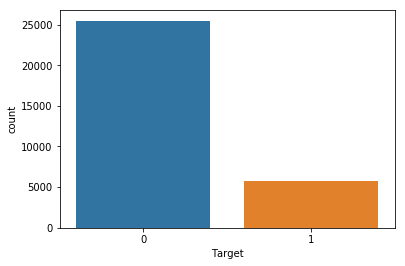

In [13]:
graph = sns.countplot(y ,label="Count")
df2["Target"].value_counts()

### Heat map

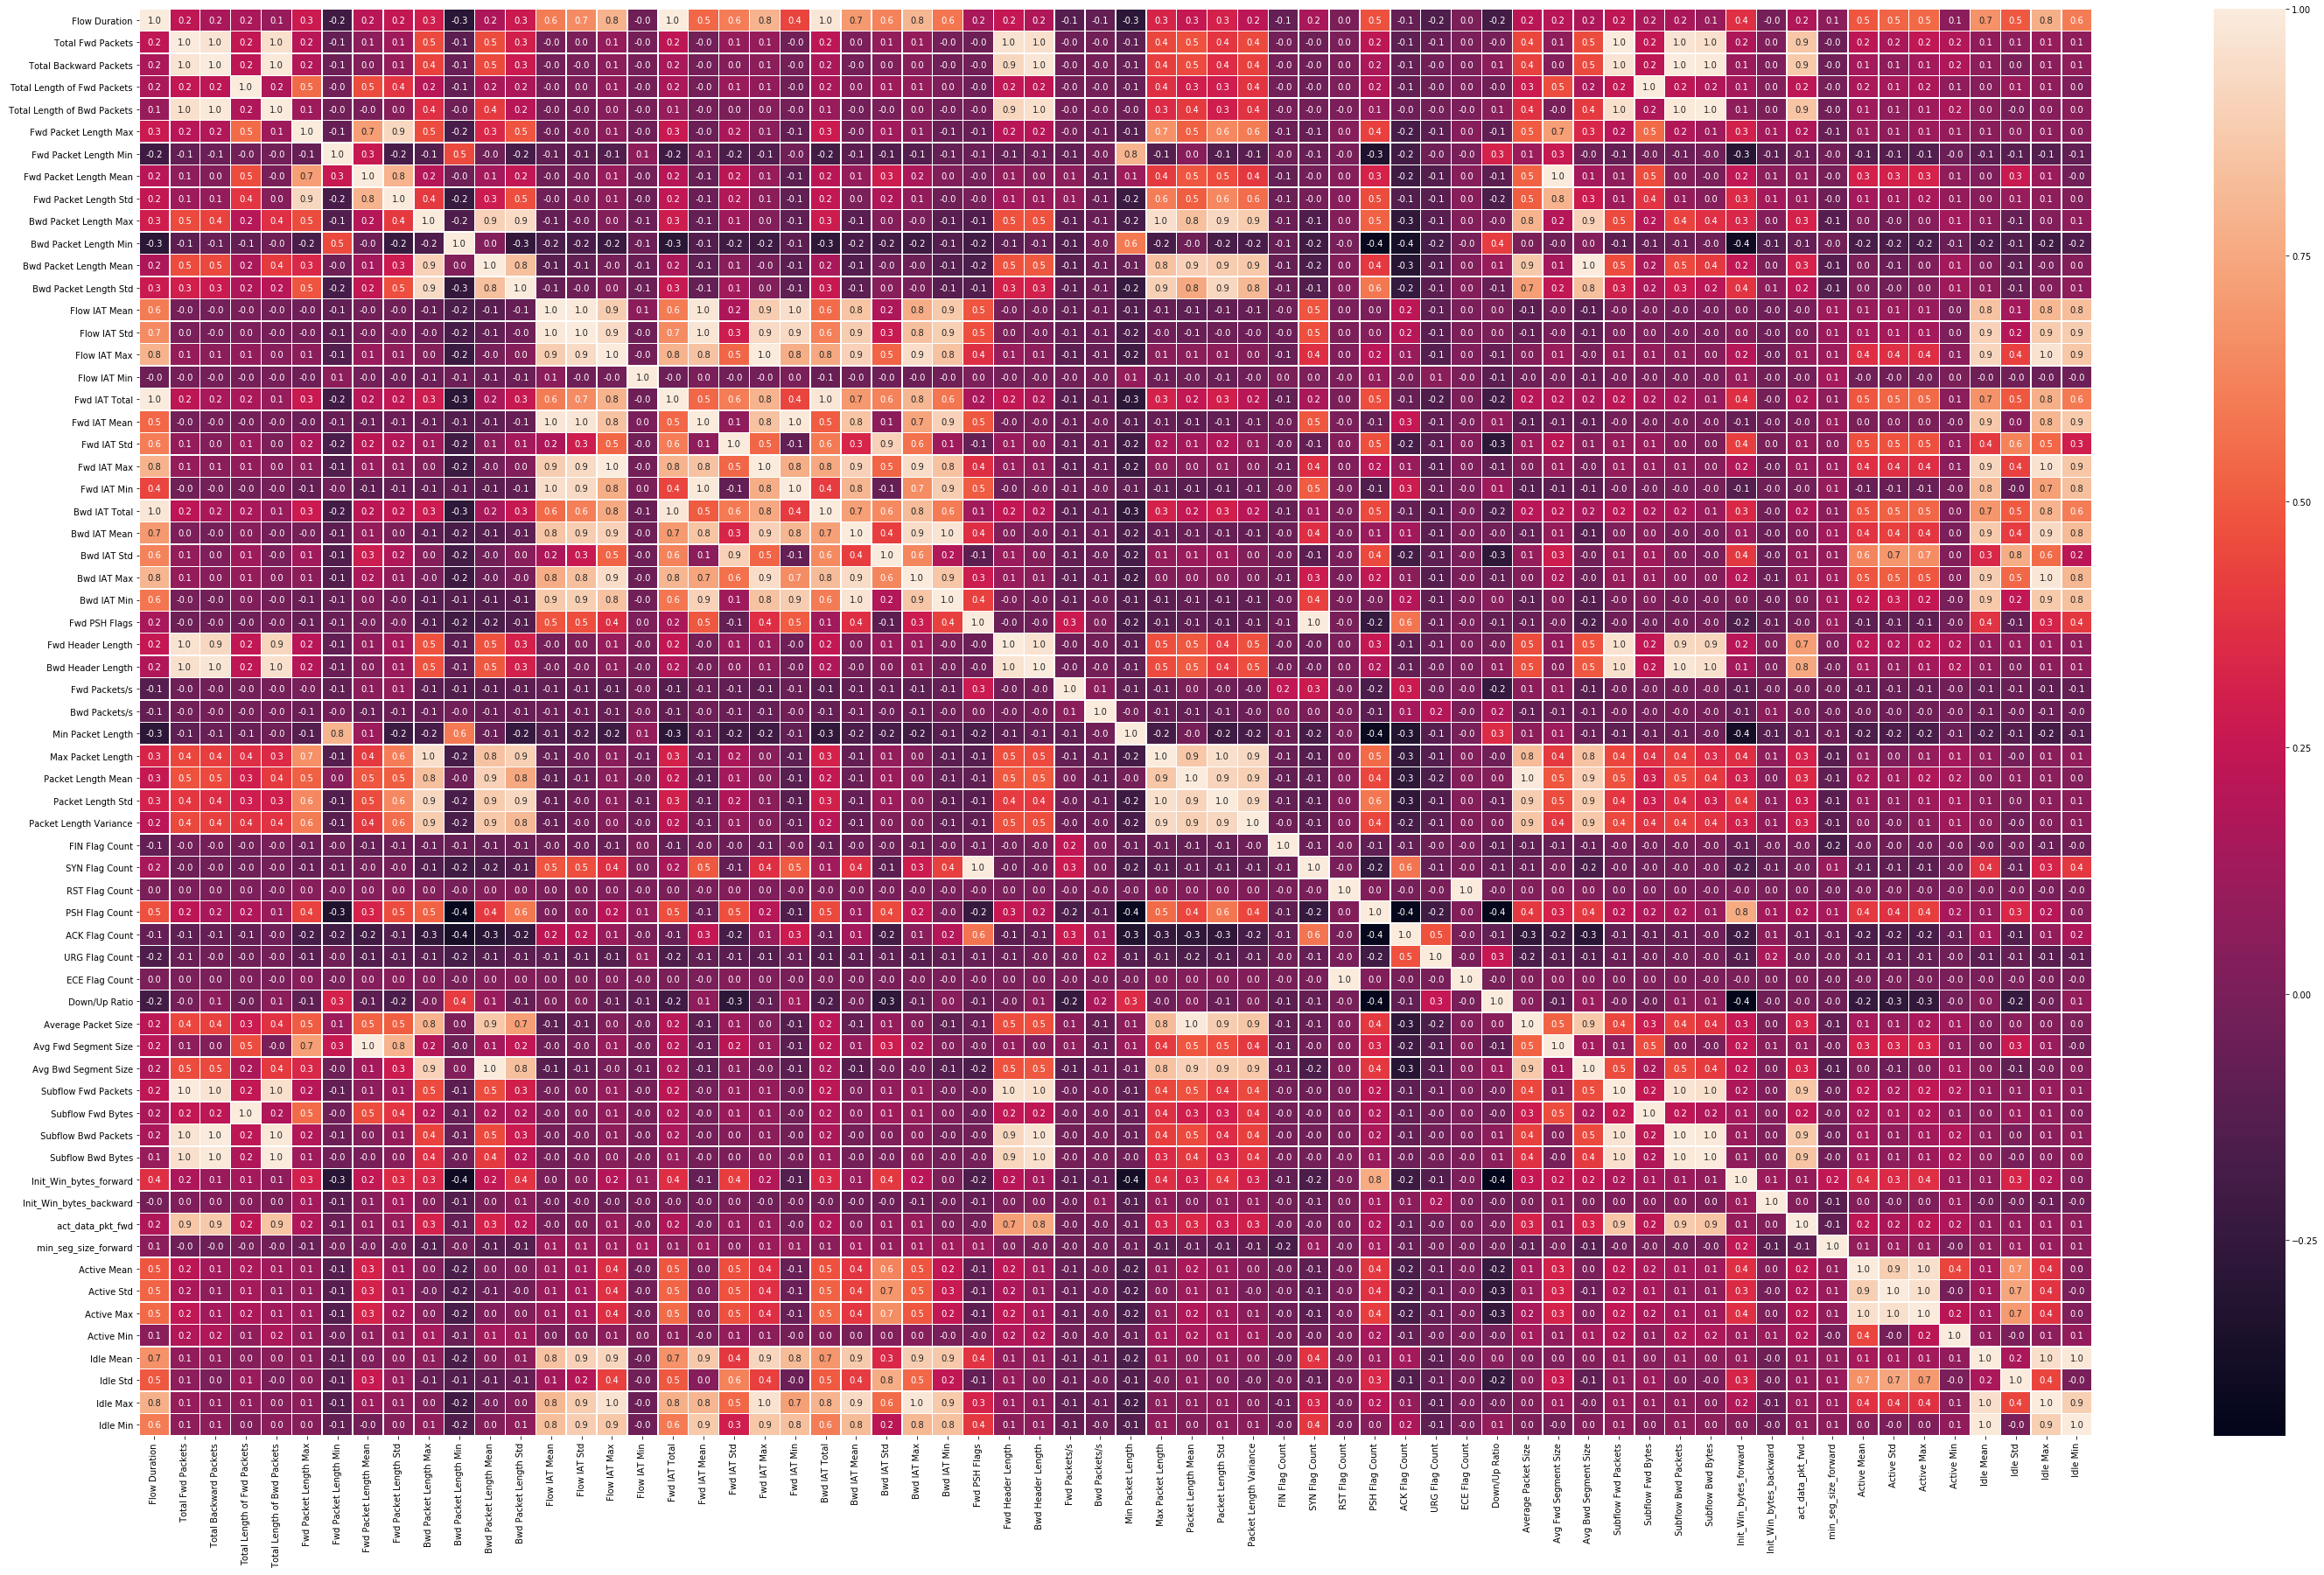

In [14]:
f, ax = plt.subplots(figsize=(50, 30))
sns_plot = sns.heatmap(X.corr(), annot=True, linewidths=.5, fmt='.1f', ax=ax)

In [15]:
sns_plot.figure.savefig("output_50_30.png")

### df2 is original data frame with neccesary processing done. From now on we make variants of data frame X and Y








# 3.0 Feature Selection


### Index
     3.1 1 Correlation
     3.2 K best features
     3.3 Recursive feature elimination with random forest
     3.4 Recursice feature elimination with cross validation and random forest
     3.5 Tree based feature selection

## 3.1 High Correlation



In [16]:
corr_matrix = X.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))


In [17]:
upper

,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,...,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
Flow Duration,NaN,0.230412,0.158531,0.164972,0.101541,0.273838,0.207387,0.209277,0.247046,0.292937,...,0.177563,0.065692,0.489157,0.526094,0.546194,0.059080,0.677048,0.491315,0.775793,0.598569
Total Fwd Packets,NaN,NaN,0.971025,0.243083,0.958453,0.207622,0.077226,0.069005,0.125934,0.455142,...,0.861757,0.037273,0.225308,0.167509,0.237077,0.185597,0.079972,0.069070,0.094757,0.067640
Total Backward Packets,NaN,NaN,NaN,0.228534,0.985396,0.187749,0.050730,0.027925,0.093306,0.431763,...,0.871536,0.041462,0.138709,0.075337,0.138812,0.178781,0.068104,0.002345,0.059938,0.067392
Total Length of Fwd Packets,NaN,NaN,NaN,NaN,0.174373,0.548558,0.030295,0.459018,0.386934,0.207482,...,0.227186,0.010736,0.158149,0.146252,0.171672,0.072040,0.039581,0.110637,0.074325,0.020309
Total Length of Bwd Packets,NaN,NaN,NaN,NaN,NaN,0.121162,0.034897,0.005393,0.040485,0.370983,...,0.851679,0.029939,0.126899,0.068248,0.120921,0.160904,0.049229,0.004051,0.041840,0.049950
Fwd Packet Length Max,NaN,NaN,NaN,NaN,NaN,NaN,0.066945,0.716392,0.925051,0.457037,...,0.173658,0.063966,0.096173,0.072379,0.116605,0.093777,0.050698,0.049660,0.059596,0.040286
Fwd Packet Length Min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.259288,0.173168,0.139677,...,0.053855,0.028934,0.132002,0.125457,0.138542,0.049082,0.103452,0.110100,0.130776,0.085195
Fwd Packet Length Mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.789659,0.197646,...,0.075213,0.007641,0.309719,0.310757,0.318219,0.073553,0.016532,0.266609,0.110040,0.029311
Fwd Packet Length Std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.405356,...,0.099720,0.046075,0.139630,0.120568,0.156141,0.089244,0.044369,0.094432,0.070062,0.026855
Bwd Packet Length Max,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.311451,0.122673,0.019525,0.031437,0.042007,0.140491,0.065394,0.066265,0.031815,0.073800


In [18]:
to_drop = [column for column in upper.columns if any(upper[column] == 1.0)]
print(len(to_drop))
print(to_drop)

7
[' SYN Flag Count', ' ECE Flag Count', ' Avg Fwd Segment Size', 'Subflow Fwd Packets', ' Subflow Fwd Bytes', ' Subflow Bwd Packets', ' Subflow Bwd Bytes']


### 3.1.2 To get an idea who all were correalted perfectly i.e 1.0

In [19]:
corrMatrix = X.corr()
corrMatrix.loc[:,:] =  np.tril(corr_matrix, k=-1)

already_in = set()
result_1 = []
for col in corrMatrix:
    perfect_corr = corrMatrix[col][corrMatrix[col] == 1].index.tolist()
    if perfect_corr and col not in already_in:
        already_in.update(set(perfect_corr))
        perfect_corr.append(col)
        result_1.append(perfect_corr)

In [20]:
for element in result_1:
    print(element)

['Subflow Fwd Packets', ' Total Fwd Packets']
[' Subflow Bwd Packets', ' Total Backward Packets']
[' Subflow Fwd Bytes', 'Total Length of Fwd Packets']
[' Subflow Bwd Bytes', ' Total Length of Bwd Packets']
[' Avg Fwd Segment Size', ' Fwd Packet Length Mean']
[' SYN Flag Count', 'Fwd PSH Flags']
[' ECE Flag Count', ' RST Flag Count']


### 3.1.4 Dropping features with 1 correlation

In [21]:
X_new = X.drop(X[to_drop], axis=1)

In [22]:
X_new.head()

,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,...,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
0,1137846,10,10,851,3950,267,0,85.100000,99.870416,1953,...,5,32,0.0,0.0,0,0,0.0,0.0,0,0
1,512617,6,7,468,635,282,0,78.000000,122.846245,458,...,3,32,0.0,0.0,0,0,0.0,0.0,0,0
2,1266840,4,3,1095,2929,1095,0,273.750000,547.500000,1481,...,1,32,0.0,0.0,0,0,0.0,0.0,0,0
3,99,2,0,0,0,0,0,0.000000,0.000000,0,...,0,32,0.0,0.0,0,0,0.0,0.0,0,0
4,307666,7,6,451,5174,451,0,64.428571,170.461977,1448,...,1,32,0.0,0.0,0,0,0.0,0.0,0,0


In [23]:
X_new.isnull().sum().sum()

0

In [24]:
def fix_data_frame(x_train):
    col = x_train.columns[x_train.dtypes.eq(object)]
    x_train[col] = x_train[col].apply(pd.to_numeric, errors='coerce', axis=1)
    return np.nan_to_num(x_train)

In [25]:
def generate_data(x, y, split, seed):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=split, random_state=seed)
    x_train = fix_data_frame(x_train)
    x_test = fix_data_frame(x_test)
    return x_train, x_test, y_train, y_test

In [26]:
def ranking(ranks, names, order=1):
    minmax = MinMaxScaler()
    ranks = minmax.fit_transform(order*np.array([ranks]).T).T[0]
    ranks = map(lambda x: round(x,2), ranks)
    return dict(zip(names, ranks))

## 3.2 K-best

In [27]:
x_train, x_test, y_train, y_test = generate_data(X_new, y, 0, 42)
ranks = {}
y_train.value_counts()

(31254,)

In [28]:
select_feature_5 = SelectKBest(f_classif, k=5).fit(x_train, y_train.values)

/home/chromares/.local/lib/python2.7/site-packages/sklearn/utils/__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


In [29]:
print("Using f_classif with Kbest returns : \n")

print("5 Features : ", X_new.columns[select_feature_5.get_support(indices=True)])
print('\n')

Using f_classif with Kbest returns : 

5 Features :  Index([u' Flow IAT Max', u' Fwd IAT Max', u' Bwd IAT Mean', u' Bwd IAT Max',
       u' Idle Max'],
      dtype='object')




#### Data feature ranking on ANOVA F-based at 30% training data

In [30]:
scores = select_feature_5.scores_
scores  = [float(i) for i in scores]
features = X_new.columns
    
k_best_f_classif = zip(scores, features)

k_best_f_classif.sort(key= lambda x : x[0], reverse=True)
for element in k_best_f_classif:
    print(element)

ranks["K-Best"] = ranking(scores, X_new.columns);

(16099.336715201352, ' Bwd IAT Max')
(15835.217395859088, ' Bwd IAT Mean')
(14815.68300855066, ' Fwd IAT Max')
(14715.303707282092, ' Flow IAT Max')
(12447.913492753783, ' Idle Max')
(10942.270539889016, ' Bwd IAT Min')
(10832.81671635916, ' Flow IAT Std')
(10657.748910018703, ' Flow IAT Mean')
(8423.980286701768, ' Active Std')
(7730.796605552552, 'Fwd IAT Total')
(7687.874516266373, ' Bwd IAT Std')
(7571.026717373476, ' Flow Duration')
(7528.727197429727, ' Idle Std')
(7407.03832585567, ' Fwd IAT Mean')
(7242.526322473509, 'Active Mean')
(7219.4752579389815, ' Active Max')
(6680.9549733034355, 'Idle Mean')
(6624.882373068998, ' min_seg_size_forward')
(6577.645199282712, 'Bwd IAT Total')
(5566.520001731477, ' Fwd IAT Min')
(5018.449742895786, ' PSH Flag Count')
(4898.775258223477, 'Init_Win_bytes_forward')
(4396.966534553808, ' Idle Min')
(3932.593333906431, ' Fwd IAT Std')
(3132.9478801377527, ' Bwd Packet Length Min')
(2906.1653223608755, 'Fwd PSH Flags')
(2865.842532989199, ' Min P

## 3.3 Recursive Feature Elimination using Random Forest

In [31]:
random_forest = RandomForestClassifier()      
rfe = RFE(estimator=random_forest, n_features_to_select=10, step=1)

In [32]:
rfe = rfe.fit(x_train, y_train.values)

In [33]:
print(rfe.support_)
print(len(rfe.support_))

[False False False  True False False False False False  True False  True
 False False False False  True False False False  True False False  True
 False False False False  True False False False False False False False
 False False False False False False False False False False  True False
  True False  True False False False False False False False False]
59


In [34]:
print('Chosen best 10 feature by rfe:', X_new.columns[rfe.support_])

rfe_features_correlated_10 = X_new.columns[rfe.support_]

Chosen best 10 feature by rfe: Index([u'Total Length of Fwd Packets', u'Bwd Packet Length Max',
       u' Bwd Packet Length Mean', u' Flow IAT Std', u' Fwd IAT Mean',
       u' Fwd IAT Min', u' Bwd IAT Min', u' Avg Bwd Segment Size',
       u' Init_Win_bytes_backward', u' min_seg_size_forward'],
      dtype='object')


In [35]:
scores = rfe.ranking_
scores  = [i for i in scores]
features = X_new.columns
    
rfe_rankings = zip(scores, features)

rfe_rankings.sort(key= lambda x : x[0])
for element in rfe_rankings:
    print(element)

(1, 'Total Length of Fwd Packets')
(1, 'Bwd Packet Length Max')
(1, ' Bwd Packet Length Mean')
(1, ' Flow IAT Std')
(1, ' Fwd IAT Mean')
(1, ' Fwd IAT Min')
(1, ' Bwd IAT Min')
(1, ' Avg Bwd Segment Size')
(1, ' Init_Win_bytes_backward')
(1, ' min_seg_size_forward')
(2, ' Packet Length Variance')
(3, ' Fwd Packet Length Mean')
(4, ' Total Length of Bwd Packets')
(5, ' Total Backward Packets')
(6, ' Fwd Header Length')
(7, ' Max Packet Length')
(8, ' Fwd IAT Max')
(9, ' Flow IAT Min')
(10, ' Bwd Packets/s')
(11, ' Fwd IAT Std')
(12, ' Fwd Packet Length Max')
(13, ' Packet Length Std')
(14, ' Flow IAT Mean')
(15, ' Packet Length Mean')
(16, ' Average Packet Size')
(17, 'Fwd IAT Total')
(18, ' Fwd Packet Length Min')
(19, 'Fwd PSH Flags')
(20, 'Fwd Packets/s')
(21, 'Init_Win_bytes_forward')
(22, ' Down/Up Ratio')
(23, 'Flow Bytes/s')
(24, ' Bwd IAT Mean')
(25, ' Fwd Packet Length Std')
(26, ' URG Flag Count')
(27, ' Flow Duration')
(28, ' Flow IAT Max')
(29, ' Idle Max')
(30, 'Bwd IAT Tot

In [36]:
random_forest = RandomForestClassifier() 
rfe = RFE(estimator=random_forest, n_features_to_select=1)
rfe.fit(x_train, y_train)

RFE(estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False),
  n_features_to_select=1, step=1, verbose=0)

In [37]:
ranks["RFE"] = ranking(list(map(float, rfe.ranking_)), X_new.columns, order=-1)

In [38]:
ranks

{'K-Best': {' ACK Flag Count': 0.0,
  ' Active Max': 0.45,
  ' Active Min': 0.0,
  ' Active Std': 0.52,
  ' Average Packet Size': 0.05,
  ' Avg Bwd Segment Size': 0.11,
  ' Bwd Header Length': 0.01,
  ' Bwd IAT Max': 1.0,
  ' Bwd IAT Mean': 0.98,
  ' Bwd IAT Min': 0.68,
  ' Bwd IAT Std': 0.48,
  ' Bwd Packet Length Mean': 0.11,
  ' Bwd Packet Length Min': 0.19,
  ' Bwd Packet Length Std': 0.06,
  ' Bwd Packets/s': 0.0,
  ' Down/Up Ratio': 0.13,
  ' Flow Duration': 0.47,
  ' Flow IAT Max': 0.91,
  ' Flow IAT Mean': 0.66,
  ' Flow IAT Min': 0.04,
  ' Flow IAT Std': 0.67,
  ' Flow Packets/s': 0.03,
  ' Fwd Header Length': 0.0,
  ' Fwd IAT Max': 0.92,
  ' Fwd IAT Mean': 0.46,
  ' Fwd IAT Min': 0.35,
  ' Fwd IAT Std': 0.24,
  ' Fwd Packet Length Max': 0.01,
  ' Fwd Packet Length Mean': 0.01,
  ' Fwd Packet Length Min': 0.06,
  ' Fwd Packet Length Std': 0.0,
  ' Idle Max': 0.77,
  ' Idle Min': 0.27,
  ' Idle Std': 0.47,
  ' Init_Win_bytes_backward': 0.01,
  ' Max Packet Length': 0.05,
  ' Mi

## 3.5 Recursive Feature Elimination with Corss Validation

In [39]:
clf_rf = RandomForestClassifier() 
rfecv = RFECV(estimator=clf_rf, step=1, cv=10, scoring='accuracy')   #10-fold cross-validation
rfecv = rfecv.fit(x_train, y_train.values)

print('Optimal number of features :', rfecv.n_features_)
print('Best features :', X_new.columns[rfecv.support_])

Optimal number of features : 16
Best features : Index([u'Total Length of Fwd Packets', u'Bwd Packet Length Max',
       u' Flow Packets/s', u' Flow IAT Mean', u' Flow IAT Min',
       u' Fwd IAT Mean', u' Fwd IAT Max', u' Fwd Header Length',
       u' Bwd Packets/s', u' Max Packet Length', u' Packet Length Std',
       u' Packet Length Variance', u' Average Packet Size',
       u' Avg Bwd Segment Size', u' Init_Win_bytes_backward',
       u' min_seg_size_forward'],
      dtype='object')


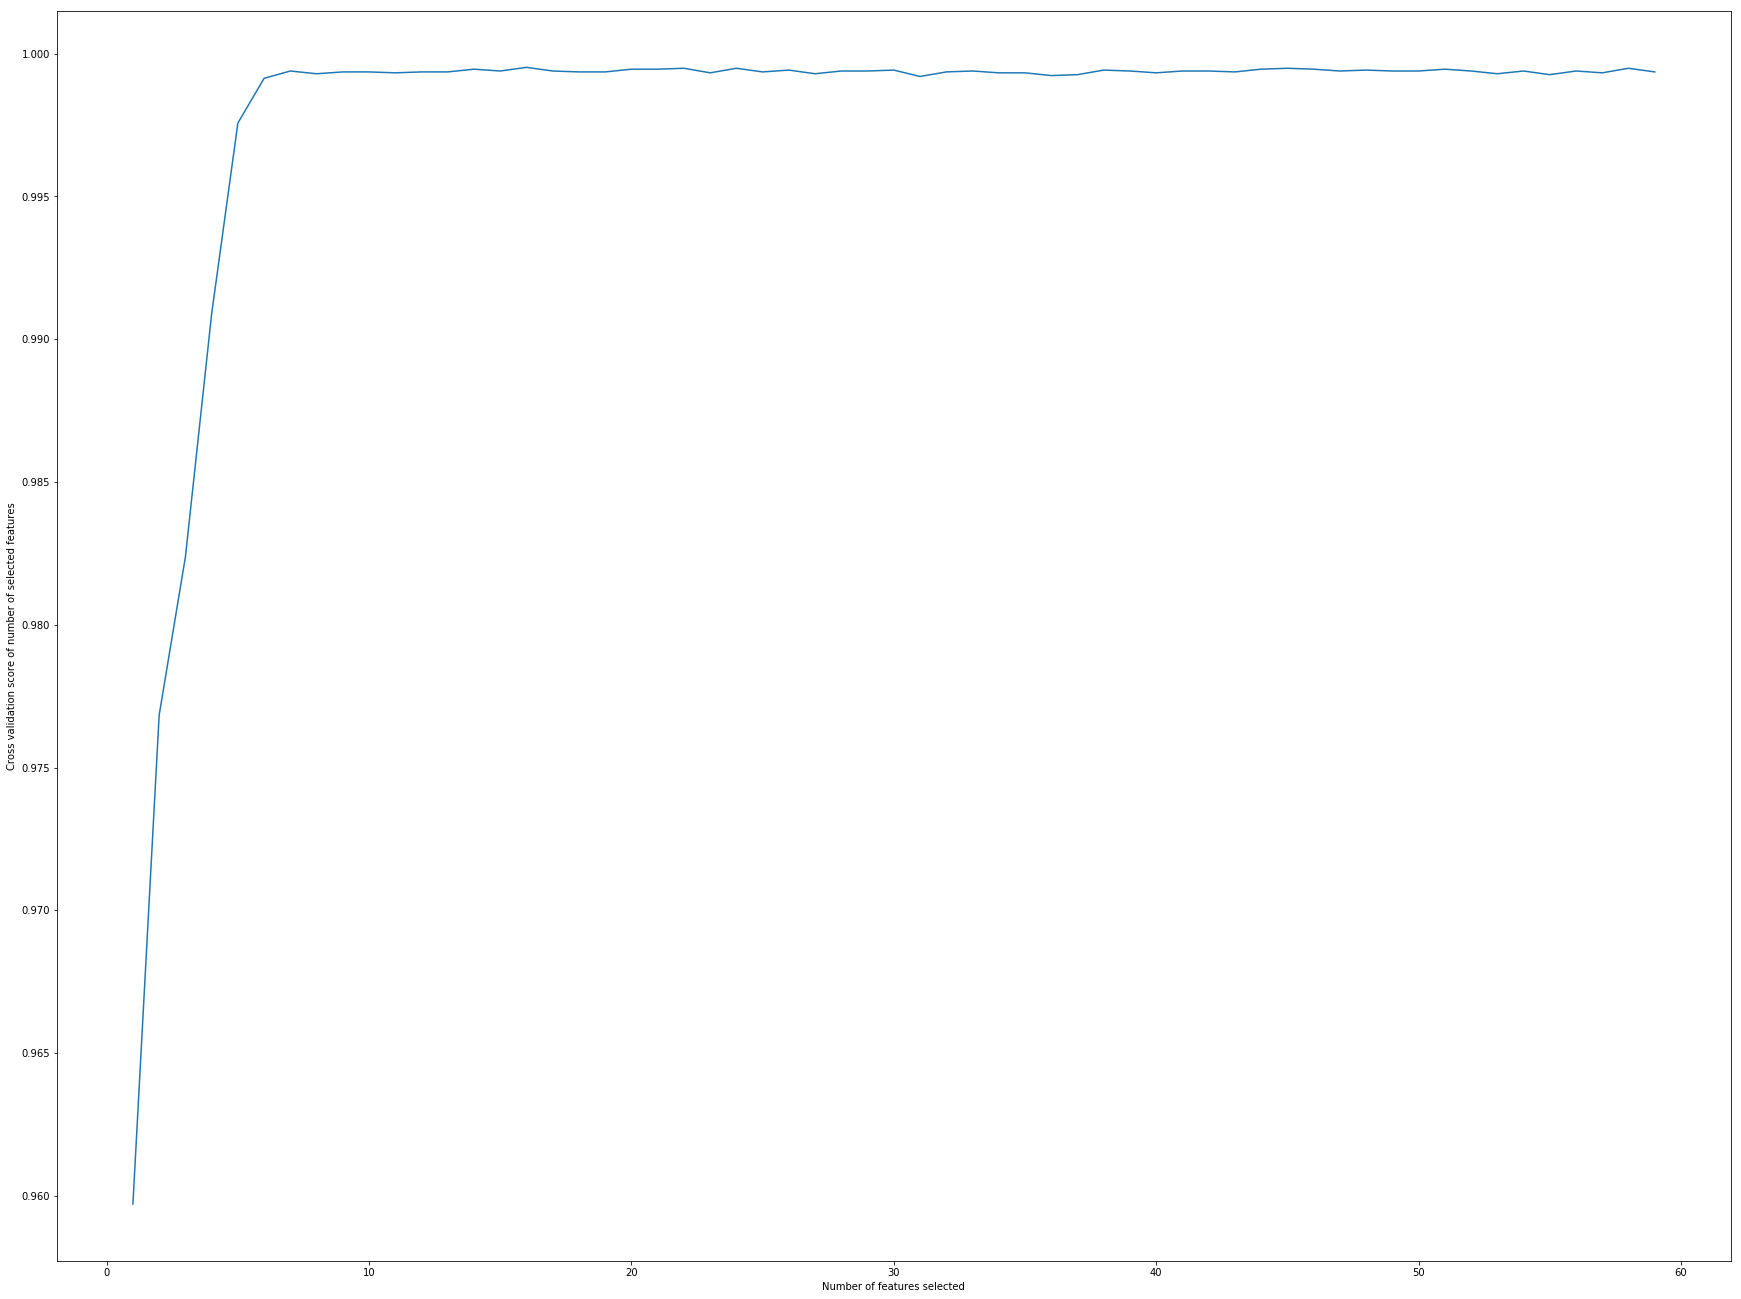

In [40]:
plt.figure(1, figsize=(30, 23))
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score of number of selected features")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.savefig("REFCV.png")

In [41]:
for element in range(len(rfecv.grid_scores_)):
    print(element + 1, rfecv.grid_scores_[element])
    

1 0.95971634859585
2 0.9768359404703684
3 0.9823705996167783
4 0.9908823646701942
5 0.9975686346572425
6 0.9991361330512009
7 0.9993921228275839
8 0.9992961433010323
9 0.9993601228210303
10 0.9993601228275839
11 0.9993280921043037
12 0.9993601433010321
13 0.9993601228275837
14 0.9994561330643081
15 0.9993921125908596
16 0.9995200921174112
17 0.9993921125843059
18 0.9993601433010323
19 0.9993601433010323
20 0.9994561125908594
21 0.9994561023541353
22 0.9994881023541351
23 0.999328112584306
24 0.9994881023475817
25 0.9993601535377566
26 0.9994241228275837
27 0.9992961535377566
28 0.9993921228275839
29 0.9993921228275837
30 0.9994241228275837
31 0.9992001637679273
32 0.999360133064308
33 0.9993921330643081
34 0.9993281330577546
35 0.9993281433010323
36 0.9992321740112052
37 0.999264174011205
38 0.999424133064308
39 0.9993921228275839
40 0.9993281535377567
41 0.9993921330643081
42 0.9993921433010323
43 0.999360133064308
44 0.9994561228275837
45 0.999488092117411
46 0.9994561228275838
47 0.

In [42]:
print(rfecv.grid_scores_[-52]) #8
print(rfecv.grid_scores_[-35]) #25
print(rfecv.grid_scores_[-46]) #14
print(X_new.shape)

print(rfecv.grid_scores_[-44]) #16
print(rfecv.grid_scores_[-46]) #14
print(rfecv.grid_scores_[-53]) #7

0.9992961433010323
0.9993601535377566
0.9994561330643081
(31254, 59)


### Tree based feature selecion

In [43]:
clf_rf = RandomForestClassifier()      
clr_rf = clf_rf.fit(x_train, y_train.values)
importances = clr_rf.feature_importances_

In [44]:
std = np.std([tree.feature_importances_ for tree in clf_rf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

print("Feature ranking:")

ranking_tree_based = []
for f in range(x_train.shape[1]):
    print(f + 1, features[indices[f]])
    ranking_tree_based.append(features[indices[f]])

ranking_tree_zip = zip(features[indices], importances[indices])
ranking_tree_zip.sort(key= lambda x : x[1], reverse=True)

for element in ranking_tree_zip:
    print(element)
    
ranks["RF"] = ranking(clf_rf.feature_importances_, X_new.columns);

Feature ranking:
1  Fwd IAT Min
2  Bwd IAT Max
3  Flow IAT Std
4  Bwd Packet Length Mean
5  Flow Packets/s
6  Total Length of Bwd Packets
7  min_seg_size_forward
8  Fwd IAT Max
9  Flow IAT Max
10  Max Packet Length
11  Fwd Header Length
12  Bwd Packets/s
13 Fwd Packets/s
14  Packet Length Variance
15 Flow Bytes/s
16  Average Packet Size
17  Flow Duration
18  Avg Bwd Segment Size
19 Total Length of Fwd Packets
20 Fwd IAT Total
21  Init_Win_bytes_backward
22  Fwd Packet Length Min
23  Packet Length Std
24  Packet Length Mean
25 Fwd PSH Flags
26  Down/Up Ratio
27  Bwd IAT Std
28  Bwd Packet Length Min
29  Fwd IAT Mean
30  Total Backward Packets
31 Init_Win_bytes_forward
32  Fwd Packet Length Mean
33  Bwd Packet Length Std
34  Fwd Packet Length Max
35 Bwd Packet Length Max
36  Min Packet Length
37  Bwd IAT Min
38 Bwd IAT Total
39  Flow IAT Min
40 Active Mean
41  Flow IAT Mean
42  Total Fwd Packets
43  Bwd Header Length
44  Bwd IAT Mean
45  URG Flag Count
46  Fwd Packet Length Std
47  Activ

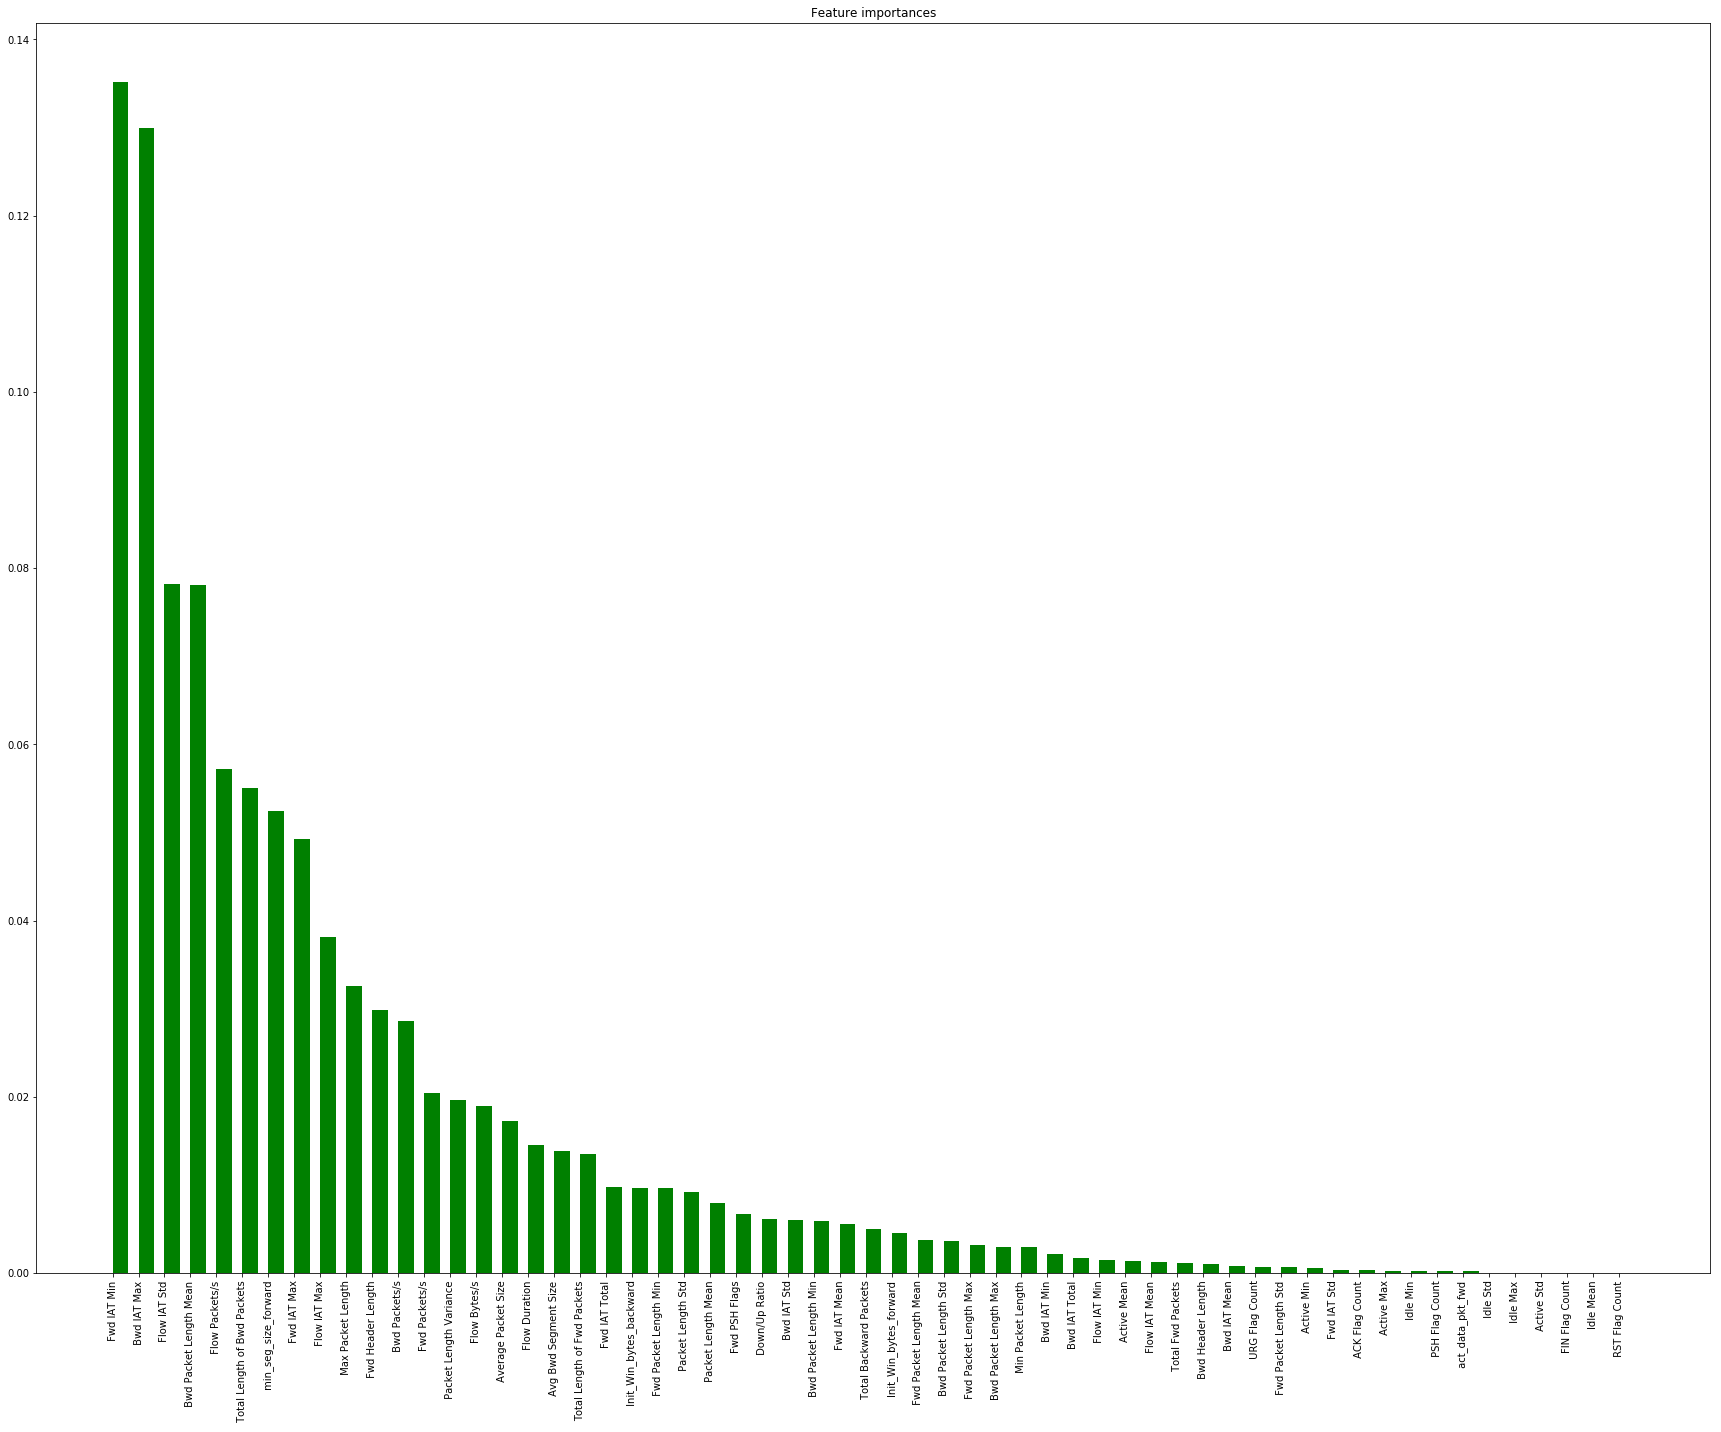

In [45]:
plt.figure(1, figsize=(30, 23))
plt.title("Feature importances")
plt.bar(range(x_train.shape[1]), importances[indices], 0.6,
       color="g", align="edge")
plt.xticks(range(x_train.shape[1]), X_new.columns[indices],rotation=90)
plt.savefig("rf_features.png")

## PCA

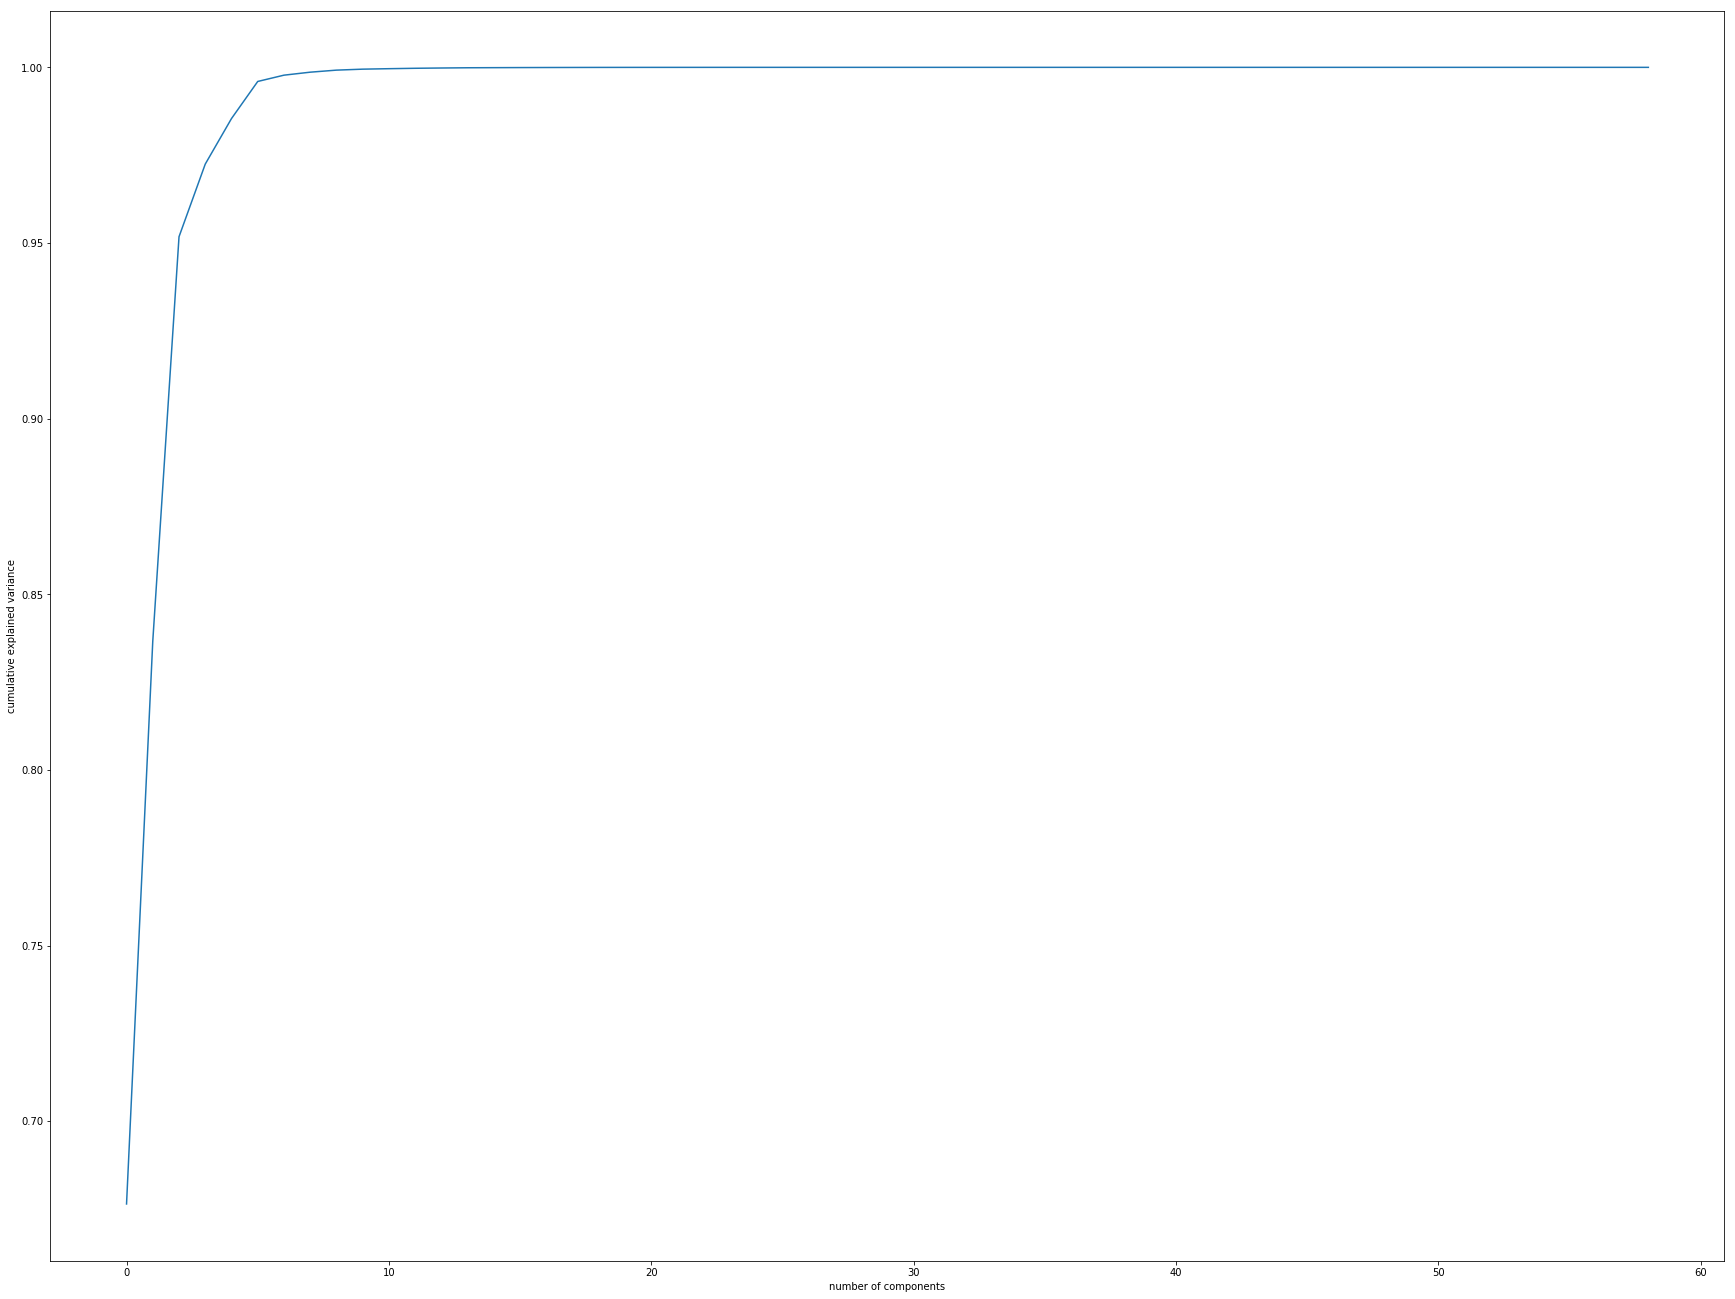

In [48]:
x_train_N = (x_train - x_train.mean())/(x_train.max() - x_train.min())
#x_test_N = (x_test - x_test.mean())/(x_test.max() - x_test.min())

pca = PCA().fit(x_train_N)
plt.figure(1, figsize=(30, 23))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');
plt.savefig("pca_cumulative.png")

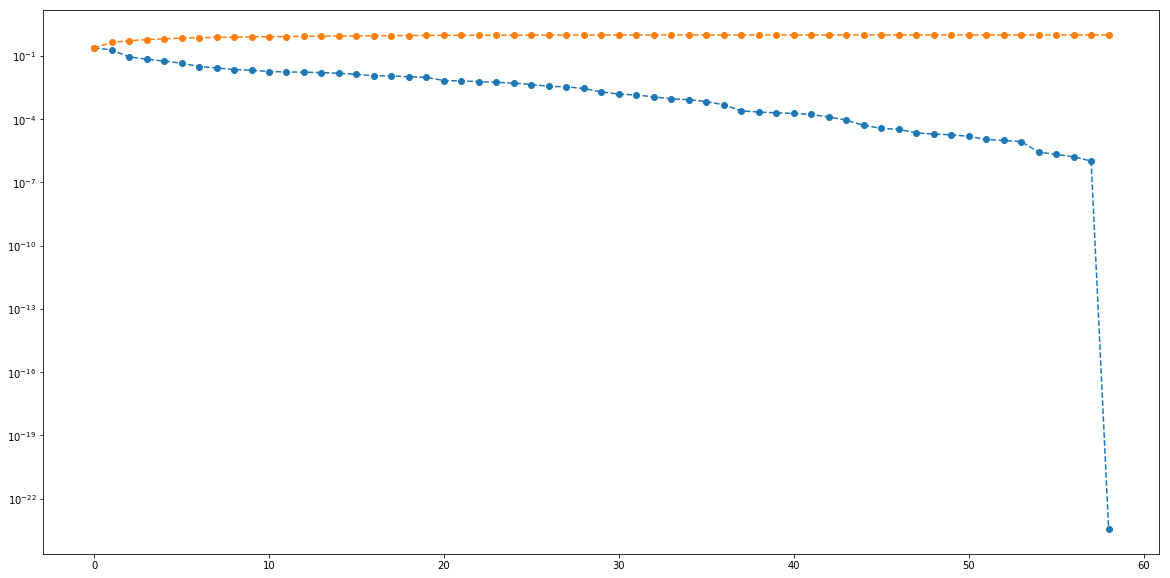

In [49]:
z_scaler = StandardScaler()

z_data = z_scaler.fit_transform(x_train)
pca_trafo = PCA().fit(z_data);

plt.figure(figsize=(20,10))
plt.semilogy(pca_trafo.explained_variance_ratio_, '--o');
plt.semilogy(pca_trafo.explained_variance_ratio_.cumsum(), '--o');
plt.savefig("pca_cumulative_individual.png")

In [50]:
variance = [0.999, 0.99, 0.98, 0.97, 0.96, 0.95, 0.90, 0.85, 0.80]
print("Original shape:   ", x_train.shape)

for i in variance:
    pca_var = PCA(i)
    pca_var.fit(x_train)
    x_var = pca_var.transform(x_train_N)
    print("Transformed shape for variance " + str(i) + " is ", x_var.shape)
    

Original shape:    (31254, 59)
Transformed shape for variance 0.999 is  (31254, 9)
Transformed shape for variance 0.99 is  (31254, 6)
Transformed shape for variance 0.98 is  (31254, 5)
Transformed shape for variance 0.97 is  (31254, 4)
Transformed shape for variance 0.96 is  (31254, 4)
Transformed shape for variance 0.95 is  (31254, 3)
Transformed shape for variance 0.9 is  (31254, 3)
Transformed shape for variance 0.85 is  (31254, 3)
Transformed shape for variance 0.8 is  (31254, 2)


## Summary

### 1. Eliminate features with 0 variance
### 2. Eliminate features with 1 correlation
### 3. Estimate feature rankings (various data set sizes) with
        K best
        Recursive feature elimination
        Recursive feature elimination with cross validation
        Random Forest
### 4. Apply PCA just to check how variance is distributed
### 5. Make a classifier with PCA and check accuracy, this will be ML solution for slowloris
### 6. Find minimal set of features for rule generation with highest accuracy
### 7. Generate rules

## Obtained Feature rankings

### 1.0 100% Split

In [51]:
print("RFECV at 100% train:")
print('Optimal number of features :', rfecv.n_features_)
print('Best features :', X_new.columns[rfecv.support_])

RFECV at 100% train:
Optimal number of features : 16
Best features : Index([u'Total Length of Fwd Packets', u'Bwd Packet Length Max',
       u' Flow Packets/s', u' Flow IAT Mean', u' Flow IAT Min',
       u' Fwd IAT Mean', u' Fwd IAT Max', u' Fwd Header Length',
       u' Bwd Packets/s', u' Max Packet Length', u' Packet Length Std',
       u' Packet Length Variance', u' Average Packet Size',
       u' Avg Bwd Segment Size', u' Init_Win_bytes_backward',
       u' min_seg_size_forward'],
      dtype='object')


In [52]:
#rfecv.score(x_test, y_test)

In [53]:
ranks

{'K-Best': {' ACK Flag Count': 0.0,
  ' Active Max': 0.45,
  ' Active Min': 0.0,
  ' Active Std': 0.52,
  ' Average Packet Size': 0.05,
  ' Avg Bwd Segment Size': 0.11,
  ' Bwd Header Length': 0.01,
  ' Bwd IAT Max': 1.0,
  ' Bwd IAT Mean': 0.98,
  ' Bwd IAT Min': 0.68,
  ' Bwd IAT Std': 0.48,
  ' Bwd Packet Length Mean': 0.11,
  ' Bwd Packet Length Min': 0.19,
  ' Bwd Packet Length Std': 0.06,
  ' Bwd Packets/s': 0.0,
  ' Down/Up Ratio': 0.13,
  ' Flow Duration': 0.47,
  ' Flow IAT Max': 0.91,
  ' Flow IAT Mean': 0.66,
  ' Flow IAT Min': 0.04,
  ' Flow IAT Std': 0.67,
  ' Flow Packets/s': 0.03,
  ' Fwd Header Length': 0.0,
  ' Fwd IAT Max': 0.92,
  ' Fwd IAT Mean': 0.46,
  ' Fwd IAT Min': 0.35,
  ' Fwd IAT Std': 0.24,
  ' Fwd Packet Length Max': 0.01,
  ' Fwd Packet Length Mean': 0.01,
  ' Fwd Packet Length Min': 0.06,
  ' Fwd Packet Length Std': 0.0,
  ' Idle Max': 0.77,
  ' Idle Min': 0.27,
  ' Idle Std': 0.47,
  ' Init_Win_bytes_backward': 0.01,
  ' Max Packet Length': 0.05,
  ' Mi

In [54]:
r = {}
for name in X_new.columns:
    r[name] = round(np.mean([ranks[method][name] 
                             for method in ranks.keys()]), 2)
 
methods = sorted(ranks.keys())
ranks["Mean"] = r
methods.append("Mean")
 
print("\t\t\t\t%s" % "\t".join(methods))
for name in X_new.columns:
    print("%s\t\t\t%s" % (name, "\t".join(map(str, 
                         [ranks[method][name] for method in methods]))))


				K-Best	RF	RFE	Mean
 Flow Duration			0.47	0.11	0.38	0.32
 Total Fwd Packets			0.0	0.01	0.1	0.04
 Total Backward Packets			0.0	0.04	0.24	0.09
Total Length of Fwd Packets			0.0	0.1	0.81	0.3
 Total Length of Bwd Packets			0.0	0.41	0.83	0.41
 Fwd Packet Length Max			0.01	0.02	0.84	0.29
 Fwd Packet Length Min			0.06	0.07	0.91	0.35
 Fwd Packet Length Mean			0.01	0.03	0.43	0.16
 Fwd Packet Length Std			0.0	0.01	0.5	0.17
Bwd Packet Length Max			0.08	0.02	0.74	0.28
 Bwd Packet Length Min			0.19	0.04	0.07	0.1
 Bwd Packet Length Mean			0.11	0.58	0.95	0.55
 Bwd Packet Length Std			0.06	0.03	0.47	0.19
Flow Bytes/s			0.01	0.14	0.57	0.24
 Flow Packets/s			0.03	0.42	1.0	0.48
 Flow IAT Mean			0.66	0.01	0.97	0.55
 Flow IAT Std			0.67	0.58	0.76	0.67
 Flow IAT Max			0.91	0.28	0.36	0.52
 Flow IAT Min			0.04	0.01	0.52	0.19
Fwd IAT Total			0.48	0.07	0.59	0.38
 Fwd IAT Mean			0.46	0.04	0.71	0.4
 Fwd IAT Std			0.24	0.0	0.29	0.18
 Fwd IAT Max			0.92	0.36	0.69	0.66
 Fwd IAT Min			0.35	1.0	0.98	0.78
Bwd IAT To

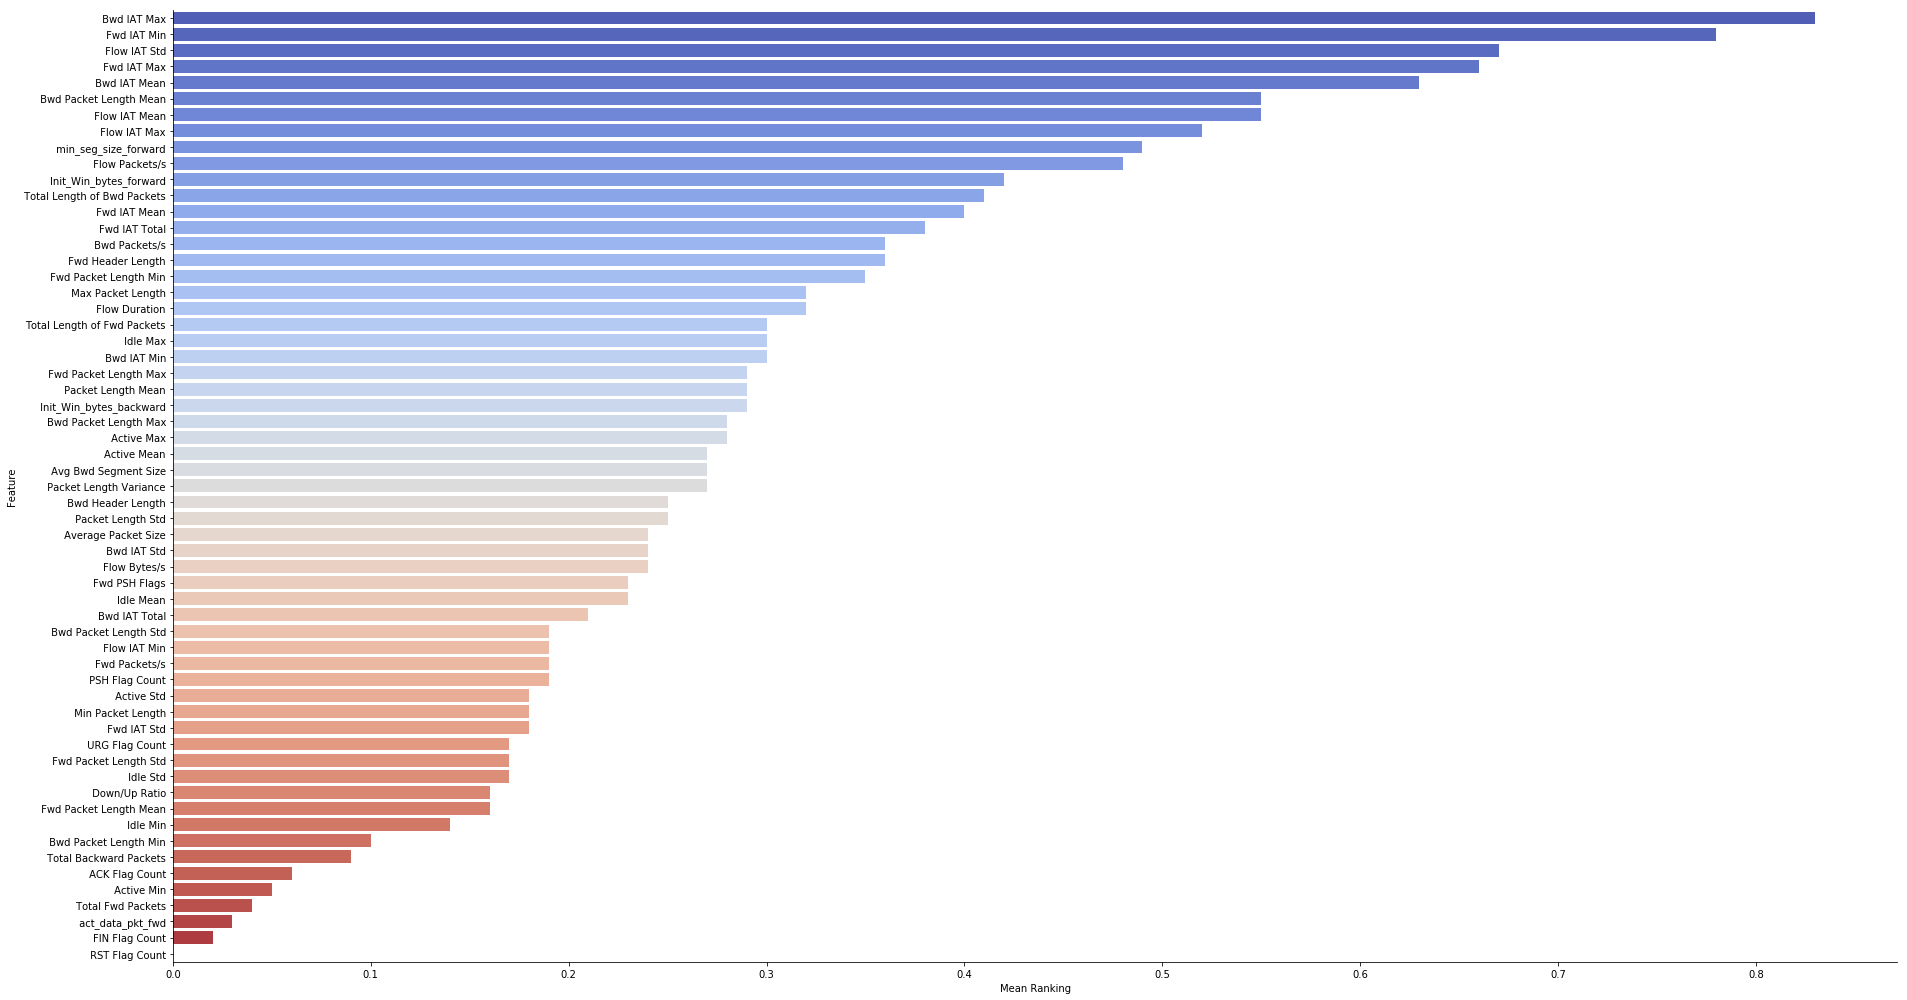

In [55]:
meanplot = pd.DataFrame(list(r.items()), columns= ['Feature','Mean Ranking'])
meanplot = meanplot.sort_values('Mean Ranking', ascending=False)
y2k = sns.factorplot(x="Mean Ranking", y="Feature", data = meanplot, kind="bar", 
               size=14, aspect=1.9, palette='coolwarm')
y2k.savefig("mean_ranking.png")

In [56]:
meanplot

,Feature,Mean Ranking
37,Bwd IAT Max,0.83
41,Fwd IAT Min,0.78
29,Flow IAT Std,0.67
50,Fwd IAT Max,0.66
10,Bwd IAT Mean,0.63
53,Bwd Packet Length Mean,0.55
35,Flow IAT Mean,0.55
38,Flow IAT Max,0.52
30,min_seg_size_forward,0.49
9,Flow Packets/s,0.48


## Testing

### Three highest grid scores were obtained at 8, 14 and 25 features. So we use these

In [59]:
#YOU CAN GENERATE DIFFERENT TRAINING SAMPLES HERE at #here. x_train, y_train is 70% by default. 

### RFE

In [65]:
for i in [8, 9, 14, 25]:
    random_forest = RandomForestClassifier()      
    rfe = RFE(estimator=random_forest, n_features_to_select=i, step=1)
    rfe = rfe.fit(x_train, y_train)
    print("RFE features at size " + str(i) + " are \n\n")
    #here
    for el in X_new.columns[rfe.support_]:
        print(el.lstrip())
    
    #for size in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
    for size in [0.1]:
        print("\n")

        training_x, testing_x, training_y, testing_y = generate_data(X_new, y, size, 42) #train classifier on x%
        training_x = rfe.transform(training_x)
        testing_x = rfe.transform(testing_x)
        print(training_y.value_counts())
        print(training_x.shape)

        clf_rf_2 = RandomForestClassifier()      
        clr_rf_2 = clf_rf_2.fit(training_x, training_y)
        ac_2 = accuracy_score(testing_y, clf_rf_2.predict(testing_x))
        print("Accuracy at " + str(size) + " for " + str(i) + " is: ", ac_2)
    

RFE features at size 8 are 


Fwd Packet Length Min
Bwd Packet Length Max
Bwd Packet Length Mean
Flow IAT Mean
Fwd IAT Min
Bwd IAT Max
Init_Win_bytes_backward
min_seg_size_forward
0    22926
1     5202
Name: Target, dtype: int64
(28128, 8)
Accuracy at 0.1 for 8 is:  0.9987204094689699
RFE features at size 9 are 


Fwd Packet Length Min
Bwd Packet Length Mean
Flow IAT Mean
Flow IAT Max
Fwd IAT Min
Bwd IAT Max
Bwd Packets/s
Packet Length Mean
Packet Length Std
0    22926
1     5202
Name: Target, dtype: int64
(28128, 9)
Accuracy at 0.1 for 9 is:  0.9990403071017274
RFE features at size 14 are 


Total Length of Bwd Packets
Fwd Packet Length Max
Fwd Packet Length Min
Bwd Packet Length Mean
Flow Packets/s
Flow IAT Mean
Flow IAT Std
Fwd IAT Min
Bwd IAT Mean
Bwd Packets/s
Average Packet Size
Avg Bwd Segment Size
Init_Win_bytes_backward
min_seg_size_forward
0    22926
1     5202
Name: Target, dtype: int64
(28128, 14)
Accuracy at 0.1 for 14 is:  0.9990403071017274
RFE features at size 25 are 



### K Best

In [66]:
for i in [8, 9, 14, 25]:
    select_feature = SelectKBest(f_classif, k=i).fit(x_train, y_train)
    print("Top " + str(i) + " features :", X_new.columns[select_feature.get_support(indices=True)])
    
    #for size in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
    for size in [0.1]:
        print("\n")
        training_x, testing_x, training_y, testing_y = generate_data(X_new, y, size, 42) #train classifier on 70%
    
        training_x = select_feature.transform(training_x)
        testing_x = select_feature.transform(testing_x)
        print(training_y.value_counts())
        print(training_x.shape)
    
        clf_rf_2 = RandomForestClassifier()      
        clr_rf_2 = clf_rf_2.fit(training_x, training_y)
        ac_2 = accuracy_score(testing_y, clf_rf_2.predict(testing_x))
        print("Accuracy at " + str(size) + " for " + str(i) + " is: ", ac_2)
    

Top 8 features : Index([u' Flow IAT Mean', u' Flow IAT Std', u' Flow IAT Max', u' Fwd IAT Max',
       u' Bwd IAT Mean', u' Bwd IAT Max', u' Bwd IAT Min', u' Idle Max'],
      dtype='object')
0    22926
1     5202
Name: Target, dtype: int64
(28128, 8)
Accuracy at 0.1 for 8 is:  0.9830454254638515
Top 9 features : Index([u' Flow IAT Mean', u' Flow IAT Std', u' Flow IAT Max', u' Fwd IAT Max',
       u' Bwd IAT Mean', u' Bwd IAT Max', u' Bwd IAT Min', u' Active Std',
       u' Idle Max'],
      dtype='object')
0    22926
1     5202
Name: Target, dtype: int64
(28128, 9)
Accuracy at 0.1 for 9 is:  0.9824056301983365
Top 14 features : Index([u' Flow Duration', u' Flow IAT Mean', u' Flow IAT Std',
       u' Flow IAT Max', u'Fwd IAT Total', u' Fwd IAT Mean', u' Fwd IAT Max',
       u' Bwd IAT Mean', u' Bwd IAT Std', u' Bwd IAT Max', u' Bwd IAT Min',
       u' Active Std', u' Idle Std', u' Idle Max'],
      dtype='object')
0    22926
1     5202
Name: Target, dtype: int64
(28128, 14)
Accuracy at

### Tree based

In [67]:
for i in [8, 9, 14, 25]:
    features_selected = ranking_tree_based[:i] 
    print(features_selected)
    x_trial = X_new[features_selected]
    print(x_trial.shape)
    
    #for size in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
    for size in [0.1]:
        print("\n")

        training_x, testing_x, training_y, testing_y = generate_data(x_trial, y, size, 42) #here
        #print(training_y.value_counts())
        clf_rf_2 = RandomForestClassifier()      
        clr_rf_2 = clf_rf_2.fit(training_x, training_y)
        ac_2 = accuracy_score(testing_y, clf_rf_2.predict(testing_x))
        print("Accuracy at " + str(size) + " for " + str(i) + " is: ", ac_2)


[' Fwd IAT Min', ' Bwd IAT Max', ' Flow IAT Std', ' Bwd Packet Length Mean', ' Flow Packets/s', ' Total Length of Bwd Packets', ' min_seg_size_forward', ' Fwd IAT Max']
(31254, 8)
Accuracy at 0.1 for 8 is:  0.9817658349328215
[' Fwd IAT Min', ' Bwd IAT Max', ' Flow IAT Std', ' Bwd Packet Length Mean', ' Flow Packets/s', ' Total Length of Bwd Packets', ' min_seg_size_forward', ' Fwd IAT Max', ' Flow IAT Max']
(31254, 9)
Accuracy at 0.1 for 9 is:  0.982085732565579
[' Fwd IAT Min', ' Bwd IAT Max', ' Flow IAT Std', ' Bwd Packet Length Mean', ' Flow Packets/s', ' Total Length of Bwd Packets', ' min_seg_size_forward', ' Fwd IAT Max', ' Flow IAT Max', ' Max Packet Length', ' Fwd Header Length', ' Bwd Packets/s', 'Fwd Packets/s', ' Packet Length Variance']
(31254, 14)
Accuracy at 0.1 for 14 is:  0.999360204734485
[' Fwd IAT Min', ' Bwd IAT Max', ' Flow IAT Std', ' Bwd Packet Length Mean', ' Flow Packets/s', ' Total Length of Bwd Packets', ' min_seg_size_forward', ' Fwd IAT Max', ' Flow IAT Ma